In [8]:
import sys
sys.path.append('../..')

import os
import json
import math

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm

import cr_interface as cri
import keras_utils as ku
import keras_bottle as kb
import keras_history as kh
import keras_weights as kw
import lib

In [3]:
def bottleneck_generator(bottlenecks, labels, n_aug, batch_size=32, shuffle=True):
    images_per_epoch = int(len(bottlenecks) / n_aug)
    batches_per_epoch = math.ceil(images_per_epoch / batch_size)

    batches_by_aug = list()

    for index in range(n_aug):
        bo, la = bottlenecks[index::n_aug], labels[index::n_aug]
        if shuffle:
            bo, la = sklearn.utils.shuffle(bo, la)
        batches = list()
        batches_by_aug.append(batches)
        for i in range(batches_per_epoch):
            i0 = i * batch_size 
            i1 = i0 + batch_size
            batches.append((bo[i0:i1], la[i0:i1]))
    
    index = 0
    while True:
        for i in range(batches_per_epoch):
            yield batches_by_aug[index][i]
        index = (index + 1) % n_aug

In [4]:
TEST = True
VERBOSE = 1
LEARNING_RATES = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def optimize(app, test=TEST, verbose=VERBOSE, batch_size=32):
    train_collection = cri.CrCollection.load().filter_by(dataset_index=0).tri_label().labeled()
    test_collection = cri.CrCollection.load().filter_by(dataset_index=1).tri_label().labeled()

    if test:
        epochs = 5
        n_aug = 1
        train_collection = train_collection.sample(frac=0.1)
        train_index = 999
        k = 5
        learning_rates = LEARNING_RATES
    else:
        epochs = 100
        n_aug = 5
        train_index = 0
        k = 5
        learning_rates = LEARNING_RATES

    k_train_sets, k_validation_sets, entire_set = kb.get_k_bottlenecks(
        app, train_collection, n_aug=n_aug, k=k, include_entire_set=True)

    min_loss_by_lr = []
    min_loss_epoch_by_lr = []
    average_histories = []

    if verbose >= 1:
        print('{}-fold, {}-learning-rate grid search'.format(
            k, len(learning_rates)).center(100, '-'))
    with tqdm(total=len(learning_rates) * k, disable=(verbose<1)) as bar:
        for lr_index, lr in enumerate(learning_rates):
            histories = []
            for i in range(k):
                train_bottles, train_labels = k_train_sets[i]
                validation_bottles, validation_labels = k_validation_sets[i]

                top_model = app.load_top_model(lr=lr)
                total = len(train_bottles)
                images_per_epoch = total / n_aug
                batches_per_epoch = math.ceil(images_per_epoch / batch_size)

                res = top_model.fit_generator(
                    bottleneck_generator(train_bottles, train_labels, n_aug=n_aug, shuffle=True),
                    validation_data=bottleneck_generator(validation_bottles, validation_labels,
                                                         batch_size=len(validation_bottles), n_aug=1, shuffle=False),
                    steps_per_epoch=batches_per_epoch,
                    validation_steps=1,
                    epochs=epochs,
                    verbose=0)

                kh.save_history(res.history, app.get_model(), lr_index, epochs, i)
                histories.append(pd.DataFrame(res.history))
                bar.update()

            average_history = pd.concat(histories).groupby(level=0).mean()
            average_histories.append(average_history)
            min_loss_by_lr.append(average_history.val_loss.min())
            min_loss_epoch_by_lr.append(average_history.val_loss.idxmin())

    min_loss = pd.Series(min_loss_by_lr).min()
    m_lr_index = pd.Series(min_loss_by_lr).idxmin()
    m_acc = pd.Series(average_histories[m_lr_index].val_acc).min()
    m_epochs = min_loss_epoch_by_lr[m_lr_index]
    m_lr = learning_rates[m_lr_index]

    if verbose >= 1:
        print('[min_val_loss: {}] val_acc: {}, lr: {}, epochs: {}'.format(
            min_loss, m_acc, m_lr, m_epochs))

    if verbose >= 1:
        print('Training and testing final model'.center(100, '-'))

    train_bottles, train_labels = entire_set
    test_bottles, test_labels = kb.load_bottlenecks(app, test_collection, aug=False)
    test_labels = lib.onehot(test_labels)

    top_model = app.load_top_model(lr=m_lr)
    res = top_model.fit_generator(
        bottleneck_generator(train_bottles, train_labels, n_aug=n_aug, batch_size=batch_size, shuffle=True),
        steps_per_epoch=batches_per_epoch,
        epochs=m_epochs,
        verbose=0)
    kw.save_weights(top_model, train_index=train_index)
    kh.save_history(res.history, app.get_model(), m_lr_index, m_epochs, split_index=None)

    loss, acc = top_model.evaluate(test_bottles, test_labels, verbose=0)
    if verbose >= 1:
        print('final accuracy: {}'.format(acc))
    kh.save_test_result(app.get_model(), loss, acc, m_lr, m_epochs)

    '''
    if verbose >= 1:
        print('Freeing bottlenecks'.center(100, '-'))
    kb.reset_bottlenecks()
    '''
    
    if verbose >= 1:
        print()
        print()


ku.run_for_all_apps(optimize, title="5-fold 5-lr grid search optimization")
lib.notify()

--------------------Running [5-fold 5-lr grid search optimization] on mobilenet---------------------
---------------------------------Number of images by split by label---------------------------------
   total  in  oap  obs
0     46  34    7    5
1     53  40    5    8
2     47  31    8    8
3     60  41   12    7
4     46  35    4    7
---------------------------------------Generating bottlenecks---------------------------------------
(1/3) generating unaugmented bottlenecks
loading mobilenet model
(2/3) generating inner train bottlenecks
(3/3) generating outer train bottlenecks
----------------------------------------Loading bottlenecks-----------------------------------------
Loading split 1 of 5...
Loading split 2 of 5...
Loading split 3 of 5...
Loading split 4 of 5...
Loading split 5 of 5...


  0%|          | 0/25 [00:00<?, ?it/s]

--------------------------------5-fold, 5-learning-rate grid search---------------------------------


KeyboardInterrupt: 

In [20]:
app = ku.apps['mobilenet']
K = 5
EPOCHS = 5
LEARNING_RATES = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

def load_average_history_by_lr(app, epochs=EPOCHS, k=K):
    histories = {}
    for lr_index, lr in enumerate(LEARNING_RATES):
        histories[lr] = kh.load_average_history(
            app.get_model(), lr_index, epochs, k=k)
    return histories

def plot_single_metric_average_history_by_lr(app, metric='val_acc', epochs=EPOCHS, k=K):
    h = load_average_history_by_lr(app=app, epochs=EPOCHS, k=5)
    single_metric = {}
    for lr, history in h.items():
        single_metric[lr] = history[metric]
    return pd.DataFrame(single_metric).plot(
        title='{}: {} by learning-rate'.format(app.name, metric),
        figsize=(10, 5),
    )

    
def generate_all_test_results():
    results = {}
    for app in ku.apps.values():
        try:
            results[app.codename] = kh.load_test_result(app.get_model())
            plot_single_metric_average_history_by_lr(app, 'val_acc').get_figure().savefig(
                '{}_val_acc_by_lr.png'.format(app.codename), dpi=160)
            plot_single_metric_average_history_by_lr(app, 'val_loss').get_figure().savefig(
                '{}_val_loss_by_lr.png'.format(app.codename), dpi=160)
        except Exception:
            pass
    pd.DataFrame(results).to_csv('test_results.csv')

In [23]:
kh.load_test_result(app.get_model())

{'loss': '0.4387239707853404',
 'accuracy': '0.8174904942965779',
 'lr': '0.0001',
 'epochs': '1'}

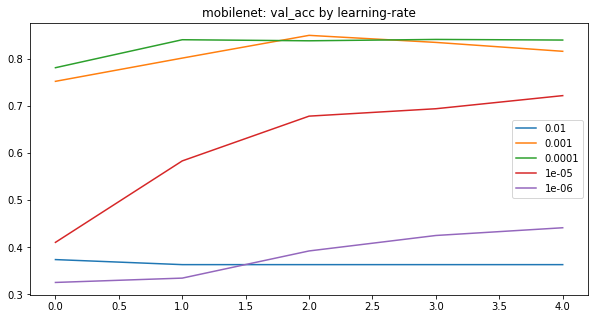

In [25]:
plot_single_metric_average_history_by_lr(app, metric='val_acc')

In [26]:
#get_all_test_results()